In [1]:
using Gen
using PyCall
using ProgressBars
pushfirst!(PyVector(pyimport("sys")."path"), "");
using PyPlot



In [2]:
SIR = pyimport("sir")
sns = pyimport("seaborn")
matplotlib = pyimport("matplotlib")
#%matplotlib inline
plt = matplotlib.pyplot
model = SIR.SIR(1000)
S,I,R  = model.project(10)
I[end]

35.707810173235266

# Probabilistic Disease Model

In [3]:
projection_days = 90; 
N = 1300000000; #1.3 Billion population of India

sigma = 100

@gen function sample_SIR()
    
    #Sample date of introduction
    intro = @trace(poisson(10), :intro) #Expected introduction 10 days from now
    days = projection_days - intro
    
    log_r0 = @trace(normal(log(2.6), 0.5), :log_r0)
    r0 = exp(log_r0)
    
    inf_period = @trace(normal(4.5, 0.5), :inf_period)
    
    model = SIR.SIR(N, r0 = r0, inf_period = inf_period)
    #S,I,R = model.project(days)
    return model
end

@gen function final_infections(sigma)
    model = @trace(sample_SIR(), :model)
    #println(model)
    final_infected = model.final_infection()[1]*model.N
    obs = @trace(normal(final_infected, sigma), :obs)
    return final_infected
end

@gen function projection(days, sigma)
    model = @trace(sample_SIR(), :model)
    S,I,R = model.project(days)
    
    infected_population = I[end]
    obs = @trace(normal(infected_population, sigma), :obs)
    return infected_population
end

@gen function peak_case_load(days, sigma)
    model = @trace(sample_SIR(), :model)
    S,I,R = model.project(days)
    
    max_load = maximum(I)
    obs = @trace(normal(max_load, sigma), :obs)
    return max_load
end
    

tr = simulate(projection, (10,100))
println(get_choices(tr))
println(tr[:model => :log_r0])


┌ Warning: `lgamma(x::Real)` is deprecated, use `(logabsgamma(x))[1]` instead.
│   caller = traceat(::Gen.GFSimulateState, ::Gen.Poisson, ::Tuple{Int64}, ::Symbol) at poisson.jl:11
└ @ Gen /home/ajshah/.julia/packages/Gen/qL5ue/src/modeling_library/poisson.jl:11


│
├── :obs : -128.2105658498664
│
└── :model
    │
    ├── :log_r0 : 0.18713977785138514
    │
    ├── :inf_period : 5.223457867052005
    │
    └── :intro : 11

0.18713977785138514


# MH Sampling

**Gaussian drift proposal**


In [4]:
sigma_r0 = 0.001
sigma_inf = 1

#Block resampling for date of introduction

@gen function drift_proposal(tr, sigma_r0, sigma_inf)
    
    #perturb r0/
    
    @trace(normal(tr[:model => :log_r0], sigma_r0), :model => :log_r0)
    
    #perturb infection period
    @trace(normal(tr[:model => :inf_period], sigma_inf), :model => :inf_period)
    
    #@trace(poisson(10), :model => :intro)
    end;

# tr = simulate(projection,(10, 100))
# println(get_choices(tr))
# tr = simulate(drift_proposal, (tr, sigma_r0, sigma_inf))
# println(get_choices(tr))

    

**Final Infections**

In [17]:
observed_final_infections = 100000000 #100 million final infections
nsamples = 50000
burn = 10000
samples = []
r0s = []
inf_periods = []

constraints = choicemap()
constraints[:obs] = observed_final_infections

#Draw and discard burning samples
tr,_ = generate(final_infections, (100,), constraints)
push!(samples, tr)
for i = tqdm(1:burn)    
    (tr, _) = mh(tr, drift_proposal, (sigma_r0, sigma_inf))
end

#Now collect the samples
for i = tqdm(1:nsamples)
    (tr, flag) = mh(tr, drift_proposal, (sigma_r0, sigma_inf))
    if flag
        push!(samples, tr)
    end
end

r0s_final = []
inf_periods_final = []
for i = 2:length(samples)
    push!(r0s_final, exp(samples[i][:model=>:log_r0]))
    push!(inf_periods_final, samples[i][:model=>:inf_period])
end


┌ Warning: `lgamma(x::Real)` is deprecated, use `(logabsgamma(x))[1]` instead.
│   caller = traceat(::Gen.GFUpdateState, ::Gen.Poisson, ::Tuple{Int64}, ::Symbol) at poisson.jl:11
└ @ Gen /home/ajshah/.julia/packages/Gen/qL5ue/src/modeling_library/poisson.jl:11


100.00%┣████████████████████████████████████████████████████▉┫ 10000/10000 00:04<00:00, 2839.01 it/s]
100.00%┣████████████████████████████████████████████████████▉┫ 50000/50000 00:14<00:00, 3468.84 it/s]


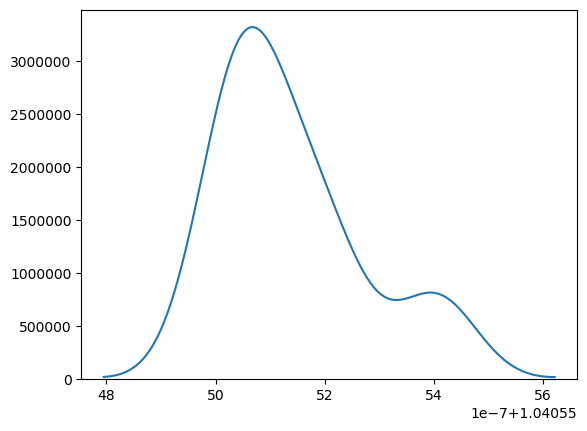

Any[1.04056, 1.04056, 1.04056, 1.04056, 1.04056, 1.04056, 1.04056]


PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7f432def6dd8>

In [19]:
println(r0s_final)
sns.kdeplot(r0s_final)

**Projections by Nth day**

In [22]:
observed_final_infections = 100000000 #100 million infections by day 100
nsamples = 50000
burn = 10000
samples = []
r0s = []
inf_periods = []

constraints = choicemap()
constraints[:obs] = observed_final_infections

#Draw and discard burning samples
tr,_ = generate(projection, (100,100), constraints)
push!(samples, tr)
for i = tqdm(1:burn)    
    (tr, _) = mh(tr, drift_proposal, (sigma_r0, sigma_inf))
end

#Now collect the samples
for i = tqdm(1:nsamples)
    (tr, flag) = mh(tr, drift_proposal, (sigma_r0, sigma_inf))
    if flag
        push!(samples, tr)
    end
end

r0s_projected = []
inf_periods_projected = []
retvals_projected = []
for i = 2:length(samples)
    push!(r0s_projected, exp(samples[i][:model=>:log_r0]))
    push!(inf_periods_projected, samples[i][:model=>:inf_period])
    push!(retvals_projected, get_retval(samples[i]))
end


println(r0s_projected)



100.00%┣█████████████████████████████████████████████████████▉┫ 10000/10000 00:13<00:00, 743.88 it/s]
100.00%┣█████████████████████████████████████████████████████▉┫ 50000/50000 01:13<00:00, 680.48 it/s]
Any[2.37395, 2.37425]


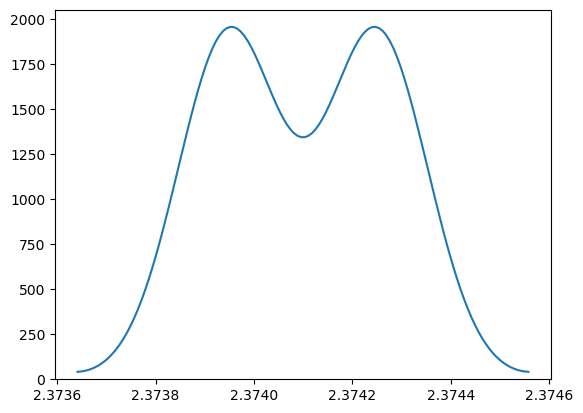

Any[2.37395, 2.37425]
Any[5.53419, 5.5352]
Any[9.99957e7, 1.00002e8]


In [29]:
println(r0s_projected)
println(inf_periods_projected)
sns.kdeplot(r0s_projected)

retvals_projected = []
for i = 2:length(samples)
    push!(retvals_projected, get_retval(samples[i]))
end

println(retvals_projected)

**Peak Case Load**

In [32]:
observed_final_infections = 100000000 #100 million peak case load
nsamples = 50000
burn = 10000
samples = []

constraints = choicemap()
constraints[:obs] = observed_final_infections

#Draw and discard burning samples
tr,_ = generate(peak_case_load, (100,100), constraints)

for i = tqdm(1:burn)    
    (tr, _) = mh(tr, drift_proposal, (sigma_r0, sigma_inf))
end
push!(samples, tr)
#Now collect the samples
for i = tqdm(1:nsamples)
    (tr, flag) = mh(tr, drift_proposal, (sigma_r0, sigma_inf))
    if flag
        push!(samples, tr)
    end
end

r0s_peak = []
inf_periods_peak = []
for i = 2:length(samples)
    push!(r0s_peak, exp(samples[i][:model=>:log_r0]))
    push!(inf_periods_peak, samples[i][:model=>:inf_period])
end




100.00%┣█████████████████████████████████████████████████████▉┫ 10000/10000 00:16<00:00, 607.70 it/s]
100.00%┣█████████████████████████████████████████████████████▉┫ 50000/50000 01:19<00:00, 630.42 it/s]


In [31]:
println(r0s_peak)
println(inf_periods_peak)

UndefVarError: UndefVarError: r0s_peak not defined

## Annealed ImportanceSampling

**Final Infections**

In [ ]:
final_infections = 100000000
constraints = choicemap()
constraints[:obs] = final_infections

In [14]:
#Particle Filter parameters
sigma = 50000 #Geometric schedule decay by 0.95
n_particles = 10000
n_anneal = 10 #annealing steps
n_mh_moves = 5

function decay(sigma)
    return 0.8*sigma
end

#Drift proposal parameters
sigma_r0 = 0.001
sigma_inf = 1;

Initialize the particle filter with a very broad likelihood

In [34]:
state = initialize_particle_filter(final_infections, (sigma,), constraints, 10000);

Anneal with 5 MH moves every time

In [40]:
for i_anneal = tqdm(1:n_anneal)
    #MH moves for each trace
    for i = 1:n_particles
        for j = 1:n_mh_moves
            state.traces[i],_ = mh(state.traces[i], drift_proposal, (sigma_r0, sigma_inf))
        end
    end
    
    #Anneal the observation sigma
    sigma = decay(sigma)
    particle_filter_step!(state, (sigma,), (UnknownChange(),), choicemap())
    maybe_resample!(state)
end

100.00%┣██████████████████████████████████████████████████████████████┫ 10/10 03:05<00:00, 0.05 it/s]


Sample unweighted traces

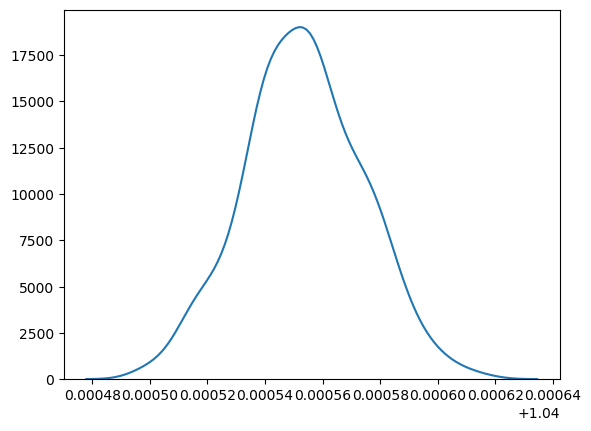

PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7f432d2fb278>

In [42]:
traces = sample_unweighted_traces(state, 500);
r0s_final = []
for i = 1:500
    push!(r0s_final, exp(traces[i][:model => :log_r0]))
end

sns.kdeplot(r0s_final)

**Projected by Nth day**

In [15]:
projected_infections = 100000000
constraints = choicemap()
constraints[:obs] = projected_infections;

In [16]:
#Particle Filter parameters
sigma = 1000000 #Geometric schedule decay by 0.95
n_particles = 5000
n_anneal = 10 #annealing steps
n_mh_moves = 5

#Drift proposal parameters
sigma_r0 = 0.001
sigma_inf = 1;

Initialize the particle filter with a very broad likelihood

In [ ]:
println(sigma)
state = initialize_particle_filter(projection, (100,sigma), constraints, n_particles);

for i_anneal = tqdm(1:n_anneal)
    #MH moves for each trace
    for i = 1:n_particles
        for j = 1:n_mh_moves
            state.traces[i],_ = mh(state.traces[i], drift_proposal, (sigma_r0, sigma_inf))
        end
    end
    
    #Anneal the observation sigma
    sigma = decay(sigma)
    particle_filter_step!(state, (100, sigma,), (UnknownChange(),), choicemap())
    maybe_resample!(state)
end

traces = sample_unweighted_traces(state, 500);
r0s_final = []
for i = 1:500
    push!(r0s_final, exp(traces[i][:model => :log_r0]))
end

sns.kdeplot(r0s_final)
println(sigma)

1000000
40.00%┣█████████████████████████▌                                      ┫ 4/10 03:37<07:15, 0.01 it/s]

In [ ]:
println(r0s_final)